# Current-based Spiking Neural Network (current-SNN)

Spike-coding network based on the paper by Barret et al. (2016). Full citation:

Barrett, D. G., Deneve, S., & Machens, C. K. (2016). Optimal compensation for neuron loss. Elife, 5, e12454.

## Install required packages

In [1]:
import numpy as np
import pylab as pl
import random
from scipy.signal import sweep_poly
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.animation as animation
import copy
import math

## Functions used for simulation

### Initialize parameters

Initialize parameters

In [2]:
def initialize_params(N, dt, iterations, beta, weights='homogeneous', gamma=0):
    """ Initialize parameters.
        
    Parameters
    ----------
    N : int
        number of neurons
    dt : int
        size between steps
    iterations : int
        length of the simulation
    beta : int
        cost
    weight : string, optional
        all neurons have same weights ("homogeneous") or neurons have different weights ("heterogeneous")
    gamma : int, optional
        read-out weight of the neurons (only applies when weights="homogeneous")
        
    Returns
    ----------
    t : 1D-array
        timesteps
    x_est : 1D-array
        input estimate per timestep
    o : array
        spike trains, with value 0 if there is no spike and value 1/dt if there is a spike,
        size (N, iterations)  
    voltage : array
        voltages, size (N, iterations) 
    D : 1D-array
        read-out weights of the neurons
    T : 1D-array
        threshold of the neurons
    
    """

    t = np.arange(0, iterations) * dt                    # time
    x_est = np.zeros(iterations)                         # input estimate
    o = np.zeros((N, iterations))                        # spike trains
    voltage = np.zeros((N, iterations))                  # voltages
    D = np.ones(N)                                       # ''output kernel''/weights
    if weights == 'homogeneous':
        D*= gamma
    elif weights == 'heterogeneous':
        D = np.random.normal(1/N, 0.5, size=(N))
    T = [(weight ** 2)/2 + beta/2 for weight in D]       # threshold

    return (t, x_est, o, voltage, D, T) 

### Time varying signal

Create time varying signal

In [89]:
def time_varying_signal(c_upp=3, tau=1):
    """ Initialize time varying input signal with a plateau. 
    
    Parameters
    ----------
    c_upp : int, optional
        value of the plateau
    
    Returns
    ----------
    x : 1D-array
        input per timestep
    c : 1D-array
        sum of the input and input derivative per timestep
        
    """

    # create time-varying signal
    x = c_upp
    x_t = np.ones(iterations) * x

    step = 150
    x_t[0:step] = 0
    x_t[iterations - 2 * step:iterations] = 0

    # smooth signal
    x = gaussian_filter1d(x_t, sigma=20)

    # compute c
    dxdt = np.diff(x)/dt
    c = x[:-1]/tau + dxdt
    
    return (x, c)

### Run simulation

In [85]:
def run(tau=1, beta=0):
    """ Run simulation of spike coding network. At each time step, the voltage and input estimate is computed
    using the Euler's method. The network follows a spike rule that if one of the voltage reaches threshold the
    network outputs a spike wherafter the voltages and input estimate are updated. """
    
    for t in range(1, iterations):

        # update input estimate
        dxestdt = -x_est[t - 1] + np.dot(D, o[:, t - 1])
        x_est[t] = x_est[t - 1] + dt * dxestdt 

        # update voltages
        dVdt = -(1/tau) * voltage[:, t - 1] + D * c[t - 1] - np.dot(D.T * D + np.identity(N) * beta, o[:, t - 1])
        voltage[:, t] = voltage[:, t - 1] + dt * dVdt

        # check for neurons with voltages above threshold
        neurons = np.arange(0, N, 1)
        above_threshold = neurons[np.where(voltage[:, t] > T)]
        
        # reset neuron when threshold is exceeded
        if len(above_threshold) > 0:

            # select random neuron who's voltage is above threshold
            spike_neuron = np.random.choice(above_threshold)

            # update spikes
            o[spike_neuron, t] = 1/dt

## Functions to visualize data

### Firing rate

Initialize exponential filter for the firing rate:

$r_{k}(t) = \int^{\infty}_{0} e^{-t'/\tau} s_{k}(t - t') dt'$

In [7]:
def exponential_filter(t, tau):
    """ Exponential filter. 
    
    Parameters
    ----------
    t : 1D-array
        timesteps
    tau : int
        rate of change
    
    Returns
    ----------
    filter : 1D-array
        exponential filter used for convolution
        
    """
    
    filter = np.exp(-t/tau)
    
    return filter

In [8]:
def firing_rate(spike_train, filt):
    """ Compute firing rate by the convolution of exponential filter and spike train. 
    
    Parameter
    ----------
    spike_train : 1D-array
        spike train
    filt : 1D-array
        filter for the convolution
    
    Returns
    ----------
    convolution : 1D-array
        convolution of the spike train with the filter
    
    """
    
    convolution = np.convolve(spike_train, filt)
    
    return convolution

Compute and plot firing rate per neuron

In [80]:
def visualize_firing_rate(tau):
    """ Compute and visualize firing rate of each neuron. """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 1/dt] = 1

    # initialize exponential filter
    tau = 1.5
    y = [exponential_filter(i, tau) for i in t]

    # initialize plots
    plots = N
    pl.subplots(plots, 1, figsize=(16, 2*N))
    counter = 1

    # compute input estimate 
    for i in range(N):

        # compute firing rate
        firingrate = firing_rate(spike_trains[i, :], y)

        # plot firing rate
        pl.subplot(plots, 1, counter)
        counter = counter + 1
        pl.plot(firingrate[0: iterations], color=color[i, :], label='N%i' %(i + 1))
        pl.ylim(0, max(firingrate) + 0.5)

### Membrane voltage

Compute voltage estimate one of two ways:

1) Computed voltage estimate using the derivative $\frac{dV_{i}}{dt} = -\frac{1}{\tau}V_{i} + D^{T}_{i} c - \sum^{N}_{k - 1} (D_{i}^{T} D_{k} + \beta \delta_{ik}) s_{k}$ referred to as the $\textbf{online method}$.

2) Compute voltage estimate using a linear readout applied to the spike trains $V_{i} = D_{i}(x - \hat{x}) - \beta r_{i}$ referred to as the $\textbf{offline method}$.

In [102]:
def visualize_voltage():
    """ Compute and visualize membrane voltage of each neuron. 
    
    Returns
    ----------
    voltage_offline : array
        voltages computed using the offline method, size (N, iterations)
    
    """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 1/dt] = 1

    # initialize exponential filter
    tau = 1
    y = [exponential_filter(i, tau) for i in t]
    
    # compute input estimate (by method 2)
    x_est_offline = np.zeros(iterations)
    for j in range(iterations):
        for i in range(N):
            firingrate = firing_rate(spike_trains[i, :], y)
            x_est_offline[j] = x_est_offline[j] + D[i] * firingrate[j] 
    
    # compute voltage (by method 2)
    voltage_offline = np.zeros((N, iterations))
    for i in range(N):
        voltage_offline[i, :] = D[i] * (x - x_est_offline)
        
    # plot voltages
    counter = 1
    pl.subplots(N, 2, figsize=(14, 4))
    for i in range(N):
        
        # plot online voltages
        pl.subplot(N, 2, counter)
        if counter == 1:
            pl.title(r'Online $\frac{dV_{i}}{dt} = -\frac{1}{\tau}V_{i} + D^{T}_{i} c - \sum^{N}_{k - 1} (D_{i}^{T} D_{k} + \beta \delta_{ik}) s_{k}$',  fontsize=20)
        counter = counter + 1
        pl.plot(t, voltage[i, :], color=color[i, :], label='N%i' %(i + 1))
        pl.plot(t, np.ones(iterations) * T[i], 'k') 
        
        # plot offline voltages
        pl.subplot(N, 2, counter)
        if counter == 2:
            pl.title(r'Offline $V_{i} = D_{i}(x - \hat{x}) - \beta r_{i}$', fontsize=20)
        counter = counter + 1
        pl.plot(t, voltage_offline[i, :], color=color[i][:], label='N%i'%(i+1))
        pl.plot(t, np.ones(iterations) * T[i], 'k')

    return voltage_offline

In [58]:
def plot_voltage_diff(voltage_online, voltage_offline):
    """ Plot difference between online and offline voltage.
    
    Parameters
    ----------
    voltage_online : array
        voltages computed using the online method, size (N, iterations)
    voltage_offline : array
        voltages computed using the offline method, size (N, iterations)
    
    """
    
    pl.rc('text', usetex=True)
    pl.plot(t, voltage_online - voltage_offline, 'k')
    pl.ylabel(r'$V_{online} - V_{offline}$')
    pl.xlabel('time')

### Inpute estimate

Compute input estimate one of two ways:

1) Computed input estimate using the derivative $\dot{\hat{x}} = -\hat{x} + \sum^{N}_{k = 1} D_{k} s_{k}$ referred to as the $\textbf{online method}$.

2) Compute input estimate using a linear readout applied to the spike trains $\hat{x} = \sum^{N}_{k = 1} D_{k} r_{k}$ referred to as the $\textbf{offline method}$.

In [116]:
def visualize_estimate():
    """ Plot estimate of the input signal. """
    
    # spike trains
    spike_trains = copy.copy(o)
    spike_trains[spike_trains == 100] = 1

    # initialize exponential filter
    tau = 1
    y = [exponential_filter(i, tau) for i in t]

    # compute input estimate (by method 2)
    x_est_offline = np.zeros(iterations)
    for j in range(iterations):
        for i in range(N):
            firingrate = firing_rate(spike_trains[i, :], y)
            x_est_offline[j] += D[i] * firingrate[j] 

    pl.subplots(1, 2, figsize=(14, 2))
    
    # plot online estimate
    pl.subplot(1, 2, 1)
    pl.title('Online $\dot{\hat{x}} = -\hat{x} + \sum^{N}_{k = 1} D_{k} s_{k}$', fontsize='20')
    pl.plot(x_est, color='gray', label=r'$\hat{x}$')
    pl.plot(x, 'k', label=r'$x$')
    
    # plot offline estimate
    pl.subplot(1, 2, 2)
    pl.title('Offline $\hat{x} = \sum^{N}_{k = 1} D_{k} r_{k}$',  fontsize='20')
    pl.plot(x_est_offline, color='gray', label=r'$\hat{x}$')
    pl.plot(x, 'k', label=r'$x$')
    
    return x_est_offline

In [105]:
def plot_estimate_diff(x_est_online, x_est_offline):
    """ Plot difference between online and offline input estimate.
    
    Parameters
    ----------
    x_est_online : 1D-array
        input estimate computed using the online method, size (iterations)
    x_est_offline : 1D-array
        input estimate computed using the offline method, size (iterations)
    
    """
    
    pl.rc('text', usetex=True)
    pl.plot(t, x_est_online - x_est_offline, 'k')
    pl.ylabel(r'$\hat{x}_{online} - \hat{x}_{offline}$')
    pl.xlabel('time')

### Visualize results simulation

Functions used to visualize results

In [5]:
def zero_to_nan(spike_trains, val = 0):
    """Replace every 0 with 'nan' and return a copy.
    
    Parameters
    ----------
    spike_trains : array
        spike trains of the different neurons
    val : int, opt
        value that is replaced by NaN
    
    Returns
    ----------
    o_Nan : array
        array where every 0 is replaced by NaN, size (spike_trains.shape)
        
    """
    
    o_Nan = [float('nan') if x==val else x for x in spike_trains]
    
    return o_Nan

In [68]:
def visualize(color, plot_voltage=True, plot_c=False):
    """ Visualize results of the simulation of the spike coding network. Return one plot with the input and input estimate,
    one plot with the spike trains, and N plots for the voltages.
    
    Parameters
    ----------
    color : array
        RGB values for the different neurons, size (N, 3)
    plot_voltages : boolean, optional
        voltages are plotted (True) or not (False)
    plot_c : boolean, optional
        sum of input plus input derivative is plotted (True) or not (False)
    
    """ 
    
    # initialize plots
    if plot_voltage == True:
        plots = 3
    else:
        plots = 2
    pl.subplots(plots, 1, figsize=(16, 8))
    pl.subplots_adjust(hspace=0.7)
    pl.rc('text', usetex=True)

    # plot input and input estimate
    pl.subplot(plots, 1, 1)
    pl.plot(t, x, label=r'$x$', color='black')
    pl.plot(t, x_est, label=r'$\hat{x}$', color='gray')
    if plot_c == True:
        pl.plot(t[:-1], c, '--k', label=r'$x + \dot{x}$', alpha=0.2)
    pl.xlim(0, iterations * dt)
    
    # plot spike trains
    pl.subplot(plots, 1, 2)
    pl.ylabel('Neuron')
    spike_times = []
    for i in range(N):
        idx = np.where(o[i, :] == 1/dt)
        temp = [t[i] for i in idx[0]]
        spike_times.append(temp)
    pl.eventplot(spike_times, linelengths=[0.5], color=color)
    pl.xlim(0, iterations * dt)
    counter = 3
    
    # plot voltages
    pl.subplot(plots, 1, counter)
    pl.ylabel('Voltage')
    if plot_voltage == 1:
        for i in range(N):
            pl.plot(t, voltage[i], color=color[i, :], label='N%i'%(i + 1), alpha=0.8)
            pl.plot(t, np.ones(iterations) * T[i], color=color[i, :], alpha=0.2)
            pl.xlim(0, iterations * dt)

## Run simulation

### $\textit{N}$-neurons

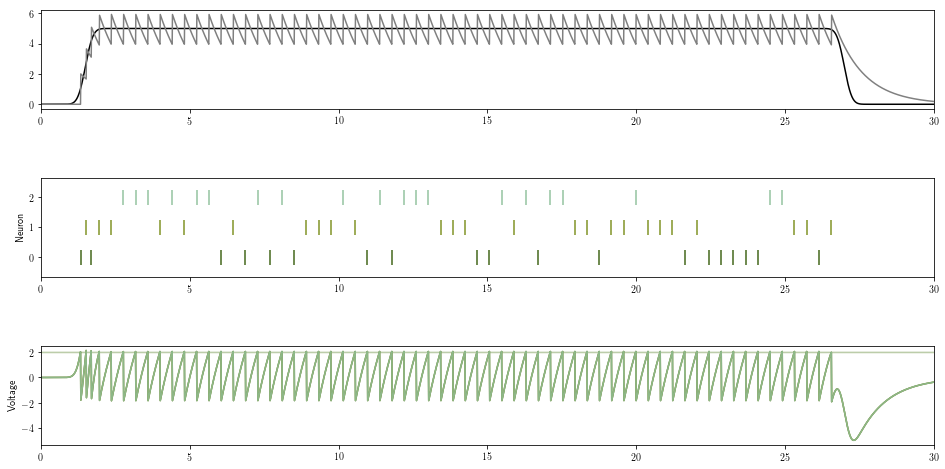

In [119]:
# network parameters
N = 3                                                    # number of neurons
c_upp = 5                                                # input value
gamma = 2                                                # read-out weight
beta = 0.0                                               # cost
tau = 1                                                  # time constant

# other
color = np.random.randint(0, 255, size=(N, 3))/255       # return set of colors
iterations = 3000                                        # length of simulation
dt = 0.01                                                # time step
weights = 'homogeneous'
plot_voltage = True 
plot_c = False

# run simulation
t, x_est, o, voltage, D, T = initialize_params(N=N, dt=dt, iterations=iterations, beta=beta, weights=weights, gamma=gamma)
x,c = time_varying_signal(c_upp=c_upp, tau=tau)
run(tau=tau, beta=beta)
visualize(color=color, plot_voltage=plot_voltage, plot_c=plot_c)

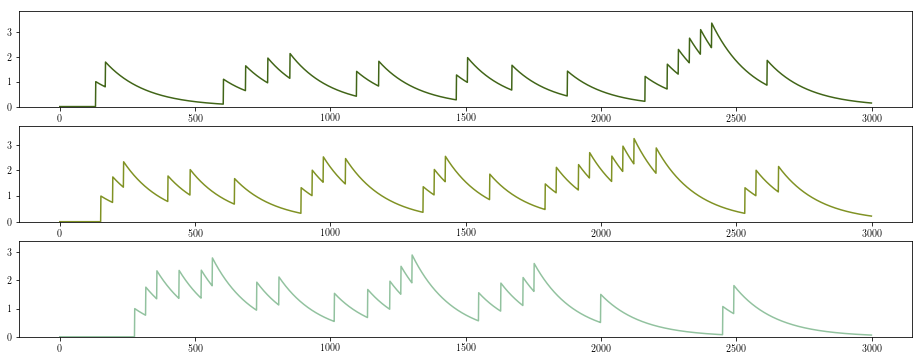

In [120]:
visualize_firing_rate(tau)

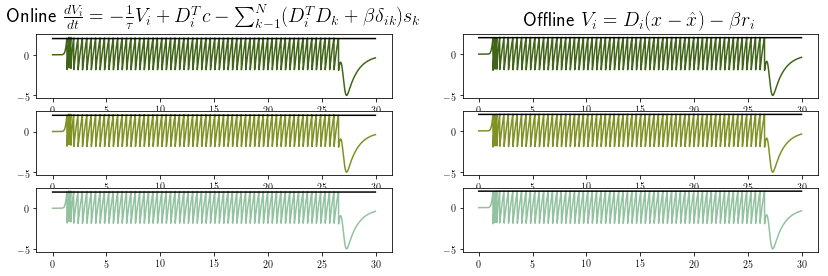

In [121]:
voltage_offline = visualize_voltage()

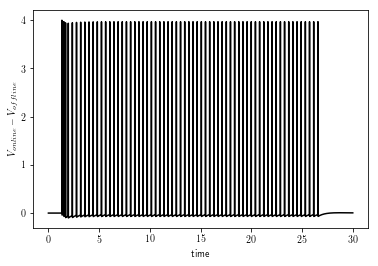

In [122]:
neuron = 1
if neuron < 1 or neuron > N:
    print("Enter valid neuron")
else:
    plot_voltage_diff(voltage[neuron - 1, :], voltage_offline[neuron - 1, :])

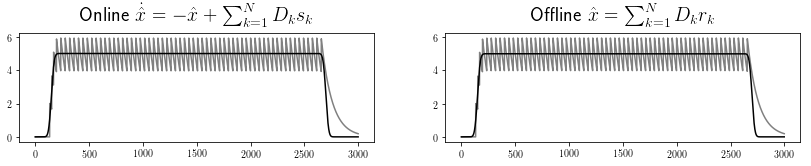

In [123]:
x_est_offline = visualize_estimate()

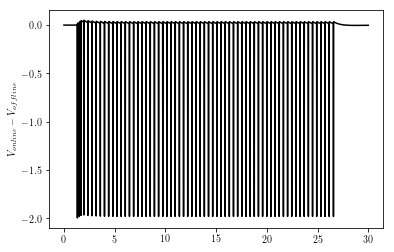

In [124]:
plot_estimate_diff(x_est, x_est_offline)

## Separate plots for voltage and input

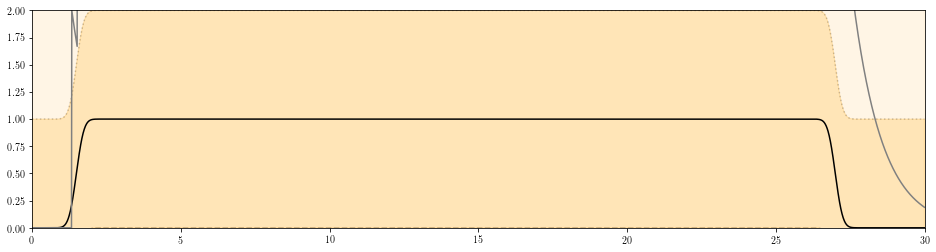

In [76]:
def LM_plot_input(input, bounding_box=True):
    """ Plots input and bounding box.
    
    Parameters
    ----------
    input : 1D-array
        signal inputs
    bounding_box : boolean, optional
        plot bounding box (True) or not (False)
    
    """
    
    # initialize input
    inputs = np.zeros(iterations)

    # creates signal
    for i in range(len(I)):
        inputs[i,:], inputsdt[i, :] = time_varying_signal(I[i])

    # computes threshold
    thresh_low = np.zeros((len(I), iterations))
    for i in range(len(I)):
        thresh_low[i, :] = [x - gamma/2 for x in inputs[i, :]]
    
    # initializes plots
    counter = 1
    fig= pl.figure(figsize=(16,4))

    #fig, ax = pl.subplots()
    for i in range(len(I)):

        counter += 1
        pl.plot(t, thresh_low[i, :], '--k', alpha=0.2)
        pl.plot(t, thresh_low[i, :] + D[i], ':k', alpha=0.2)
        pl.plot(t, inputs[i, :], 'k')
        pl.plot(t, x_est, 'gray')
        pl.xlim([0, iterations * dt])
        pl.ylim(0, 2)
        pl.xticks()
        if bounding_box == True:
            pl.fill_between(t, thresh_low[i, :], thresh_low[i, :] + D[0], color='orange', alpha=0.2)
            pl.fill_between(t, np.ones(iterations) * 20, thresh_low[i, :], color='orange', alpha=0.1)
        
I = [1]
LM_plot_input(I, bounding_box=True)

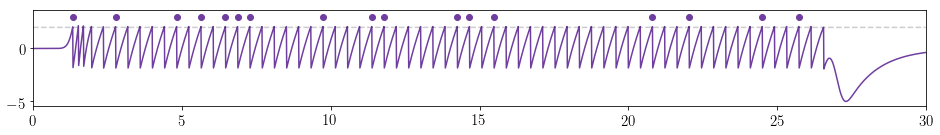

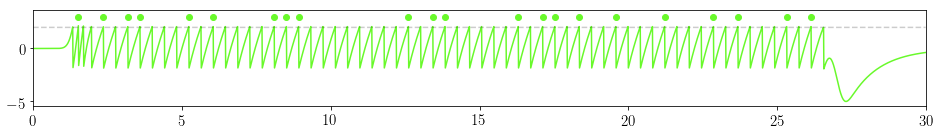

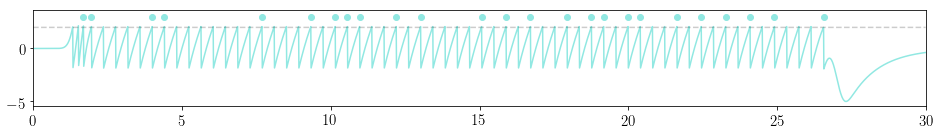

In [79]:
def LM_plot_voltage():
    """ Plot voltages, spike trains and thresholds per neuron. """
    
    counter = 1
    
    for i in range(1, N + 1):
        
        # initialize plots
        fig= pl.figure(figsize=(16,6))
        pl.subplot(N, 1, counter)
        counter = counter + 1
        pl.xlim([0, iterations * dt])
        pl.xticks()
        pl.tick_params(labelsize=15)
        
        # plot data
        pl.plot(t, voltage[i - 1], color=color[i - 1][:], label='N%i'%i)
        pl.plot(t, np.ones(iterations) * T[i - 1], '--k', alpha=0.2)
        values = zero_to_nan(o[i - 1, :] * dt * T[i - 1] + 1, 1) 
        pl.scatter(t, values, color=color[i - 1][:], label='Neuron %i' %i)
    
LM_plot_voltage()

In [113]:
def voltages_animation_2D(frames, interval=20):
    """ Plot animation of the coding error through time with respect to the bounding box.
    
    Parameters
    ----------
    frames: int
        number of frames
    interval: int, optional
        time between frames
    
    """
        
    # file
    file = 'C:/Users/amber/MachensLab/Current/' + 'N' + str(N) + '_voltages.gif'

    # initiate plots
    fig, axes = pl.subplots(N+1,1, figsize=(8, 10))
    
    point = []
    
    # initiate plot input and input estimate
    axes[0].set_ylim(0, c_upp + 1)
    axes[0].set_xlim(0, iterations * dt)
    temp, = axes[0].plot([], [], color='black')
    point.append(temp)
    temp, = axes[0].plot([], [], color='grey')
    point.append(temp)

    # input plot voltages
    for i in range(1,N + 1):
        # set axes
        axes[i].set_ylim(-1, 1.5)
        axes[i].set_xlim(0, iterations * dt)
        axes[i].set_ylabel('Voltage')
        axes[i].plot(t, np.ones(iterations) * T[i - 1], '--k', alpha=0.2)

        temp, = axes[i].plot([], [], color=color[i - 1][:]/255)
        point.append(temp)
        temp = axes[i].scatter([], [], color=color[i - 1][:]/255, marker='o')
        point.append(temp)
        
    axes[N].set_xlabel('Time')

    def animate(i):

        # update the data
        tp = t[0:i]
        
        # set input
        X = x[0:i]
        X_est = x_est[0:i]
        
        point[0].set_data(tp, X)
        point[1].set_data(tp, X_est)

        # set y data
        for n in range(1, N + 1):
            y = voltage[n - 1, 0:i]    
            point[n * 2].set_data(tp, y)
            
            data = []
            for k in range(i):
                spike = zero_to_nan([o[n - 1,k] * dt])
                data.append([t[k], spike[0]])

            data = np.asarray(data).reshape(i, 2)
            point[n * 2 + 1].set_offsets(data)

        return point

    # runs animation
    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=interval, blit=True)
    ani.save(file, writer='imagemagick') # save as .gif
    pl.show()

    return fig